# Poisson Tucker versus Dirichlet Tucker model comparison

Here, we evaluate the fit of simplex-constrained Poisson Tucker models to
data generated from a Dirichlet Tucker distribution. We aim to justify the need
for a Dirichlet Tucker distribution.

One concern is that this comparison feels like a bit of a strawman,
since data drawn from a model will naturally be a better fit. However,
we may find a progression of better fit in the Poisson Tucker varianets,
e.g. Poisson Tucker variants with stronger and more "dirichlet-like" constraints
are better fits.

In [1]:
import jax.numpy as jnp
import jax.random as jr
import numpy as onp
import optax
import pandas as pd
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.model3d import (
    DirichletTuckerDecomp
)

from dtd.fit import fit_opt
from dtd.poisson_tucker_3d import (
    L2PenalizedMultinomialTucker,
    SimplexMultinomialTucker
)

# Generate data

In [3]:
full_shape = (500, 100, 50)
core_shape = (20, 10, 5)
total_counts = 100

In [36]:
key = jr.PRNGKey(42)
key_true, key_other = jr.split(key)
key_true, key_data, key_mask = jr.split(key_true, 3)

# Instantiate the "true" model and generate observations from it
true_model = DirichletTuckerDecomp(total_counts, *core_shape)
true_params = true_model.sample_params(key_true, *full_shape)
X = true_model.sample_data(key_data, true_params)
X_mask = jr.bernoulli(key_mask, 0.8, shape=full_shape[:-1])

In [208]:
key_proj, key_l2, key_simplex, key_dtd = jr.split(key_other, 4)

# Define objective function
def make_objective_fn(log_prior_weight: float=1):
    def objective_fn(model) -> float:
        """Objective function, differentiate with respect to first argument."""
        lp = jnp.where(X_mask, model.log_likelihood(X), 0.0)
        lp += log_prior_weight * model.log_prior()
        lp /= X_mask.sum()
        return -lp.sum()
    return objective_fn


# L2-penalized Multivariate Tucker

In [152]:
# THIS TAKES ~25 minutes to run on CPU, so be careful accidentally re-running
# model_klass = L2PenalizedMultinomialTucker
# optimizer = optax.adam(1e-2)

# n_iters = 1000
# n_runs = 5
# log_prior_weights = [1, 2.5, 5, 7.5, 10, 25, 50, 100, 500, 1000]

# # --------------------------------------------------------------------------
# n_conditions = len(log_prior_weights)
# l2_model_results_dict = {}

# all_models, all_train_ll, all_vldtn_ll = [], [], []
# for key_l2_, log_prior_weight in zip(jr.split(key_l2, n_conditions), log_prior_weights):

#     objective_fn = make_objective_fn(log_prior_weight)

#     all_models, all_train_ll, all_vldtn_ll = [], [], []
#     for i_run, key_ in enumerate(jr.split(key_l2_, n_runs)):
#         # Initialize model and optimizer
#         model = model_klass.random_init(key_, full_shape, core_shape, total_counts)
#         opt_state = optimizer.init(model)

#         # Fit with default iter_callback
#         (model, _), outputs = fit_opt(model, X, X_mask,
#                                       objective_fn,
#                                       optimizer, opt_state,
#                                       n_iters=n_iters)

#         # Save
#         all_models.append(model)
#         all_train_ll.append(outputs.train_ll)
#         all_vldtn_ll.append(outputs.vldtn_ll)
    
#     all_train_ll = jnp.stack(all_train_ll)
#     all_vldtn_ll = jnp.stack(all_vldtn_ll)

#     l2_model_results_dict[log_prior_weight] = dict(
#         model = all_models,
#         train_ll = all_train_ll,
#         vldtn_ll = all_vldtn_ll
#     )

In [153]:
log_prior_weights = list(l2_model_results_dict.keys())

l2_color_palette = \
    sns.cubehelix_palette(n_colors=len(log_prior_weights), start=2, rot=0,
                          dark=0.1, light=.9, )

l2_color_palette


[[0.8499788704199769, 0.9348975047602627, 0.8670683429450211],
 [0.7326940831069072, 0.874678039723865, 0.7612676811687812],
 [0.6284073586037797, 0.8126291055186883, 0.6654811116955017],
 [0.5266900244602813, 0.7425458087242146, 0.5701299775778546],
 [0.4372294458329359, 0.6711027490351559, 0.4842953392079968],
 [0.3550011334864599, 0.5950771891100572, 0.4033153013763936],
 [0.2764451321074458, 0.5103184353096657, 0.32351102548250665],
 [0.20904296563675195, 0.4248987499006852, 0.25248291875432516],
 [0.14605441742730907, 0.3302761643422176, 0.18312817051903107],
 [0.09347839683239748, 0.2354623534493552, 0.12205199489427138],
 [0.046057301792525936, 0.13097593613281167, 0.06314677431757014]]

Text(0.5, 1.0, 'L2PenalizedMultinomialTucker vs. regularization strength')

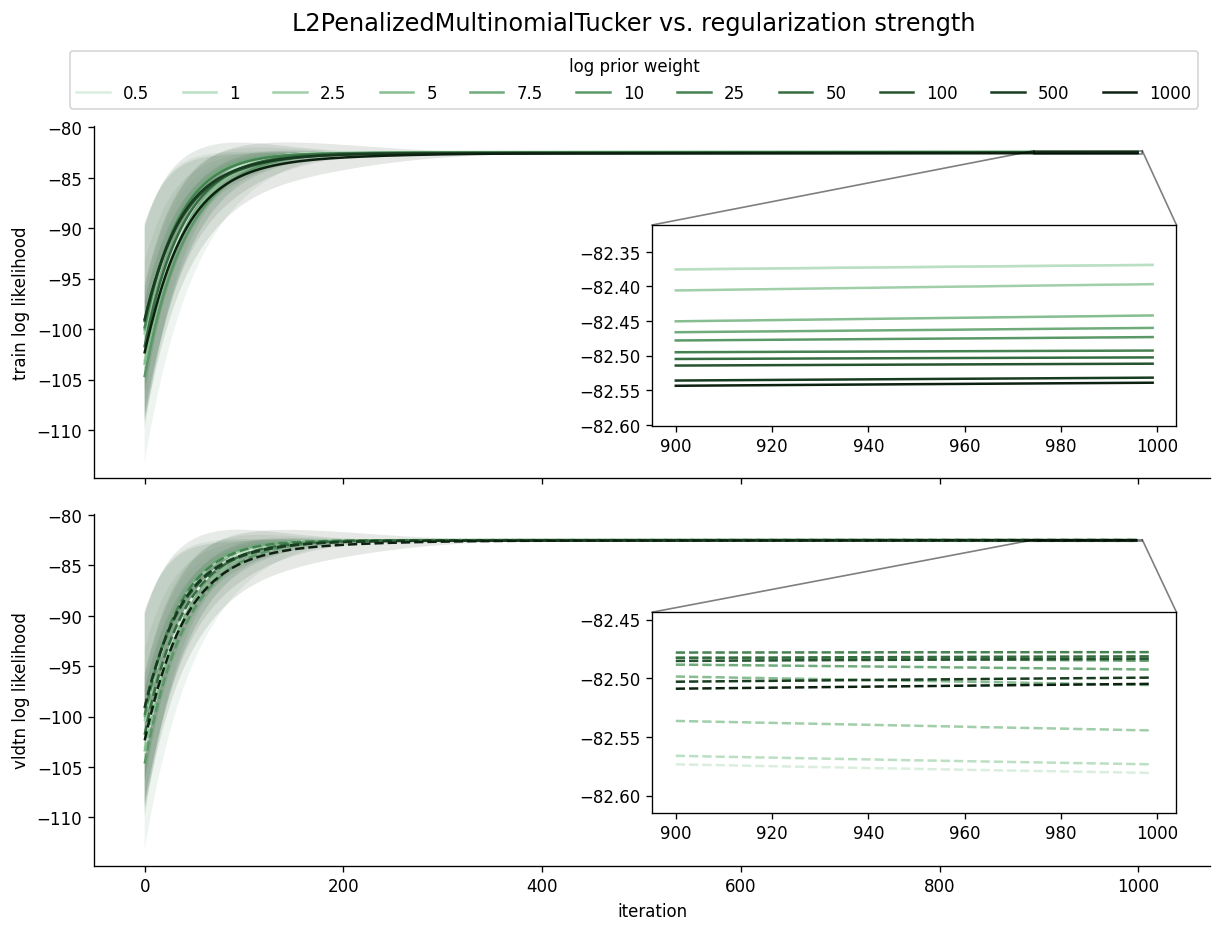

In [179]:
fig, axs = plt.subplots(nrows=2, sharex='col', gridspec_kw={'hspace':0.1},
                        figsize=(12,8), dpi=120)

inset_idxs = jnp.arange(n_iters-100, n_iters)

for i_row, (ll_type, ls) in enumerate([('train_ll', '-'), ('vldtn_ll', '--')]):
    ax_main = axs[i_row]
    ax_inset = ax_main.inset_axes([0.5, 0.15, 0.47, 0.57],)

    for i_weight, (weight, results) in enumerate(l2_model_results_dict.items()):
        # c_weight = l2_color_palette(l2_color_norm(weight))
        c_weight = l2_color_palette[i_weight]

        ll = results[ll_type]
        ll_mean = jnp.mean(ll, axis=0)
        ll_std = jnp.std(ll, axis=0)
        
        ax_main.plot(jnp.arange(n_iters), ll_mean, c=c_weight, ls=ls)
        ax_main.fill_between(jnp.arange(n_iters),
                            ll_mean-2*ll_std, ll_mean+2*ll_std,
                            fc=c_weight, alpha=0.1)
        
        ax_inset.plot(inset_idxs, ll_mean[inset_idxs], c=c_weight, ls=ls)
        ax_main.fill_between(inset_idxs,
                            (ll_mean-ll_std)[inset_idxs],
                            (ll_mean+ll_std)[inset_idxs],
                            fc=c_weight, alpha=0.1)
        
    # Increase inset margins
    ax_inset.margins(y=0.33)

    # Indicate inset
    ax_main.indicate_inset_zoom(ax_inset, edgecolor='black')

    # Make pretty
    ax_main.set_ylabel(f"{ll_type.split('_')[0]} log likelihood")
    sns.despine(ax=ax_main)

axs[-1].set_xlabel('iteration')

# Add legend
handles = [
    mpl.lines.Line2D([0],[0], c=l2_color_palette[i_weight], label=f'{weight}')
    for i_weight, weight in enumerate(log_prior_weights)
]

# fig.legend(handles=handles, loc='center left', bbox_to_anchor=[0.92,0.5],
#            title='log prior weight')

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=[0.5, 0.89],
           ncol=len(handles), title='log prior weight')

fig.suptitle(f'{model_klass.__name__} vs. regularization strength', fontsize='x-large', y=1.0)

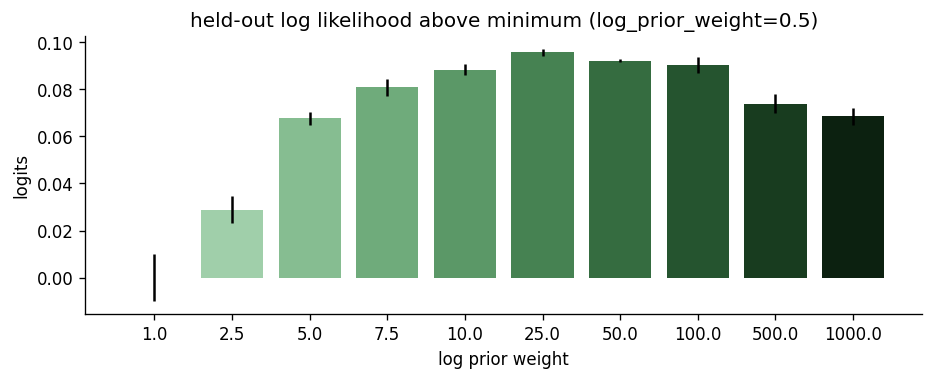

In [182]:
fig, ax = plt.subplots(figsize=(9,3), dpi=120)

ll_means = onp.array([
    onp.mean(results['vldtn_ll'][:,-1]) for results in l2_model_results_dict.values()
])
ll_stds = onp.array([
    onp.std(results['vldtn_ll'][:,-1]) for results in l2_model_results_dict.values()
])

i_weights = onp.arange(len(log_prior_weights))
rects = ax.bar(i_weights, ll_means-onp.min(ll_means), yerr=ll_stds,
               color=l2_color_palette,
               tick_label=log_prior_weights)
ax.set_xlabel('log prior weight')
ax.set_ylabel('logits')
ax.set_title("held-out log likelihood above minimum "
             f"(log_prior_weight={log_prior_weights[onp.argmin(ll_means)]})")
sns.despine(ax=ax)

# Simplex Constrained Tucker

In [205]:
model_klasses = [
    SimplexMultinomialTucker,
    L2PenalizedMultinomialTucker,
]

model_color_palette = [
    (0.18653861642264968, 0.3669177984726364, 0.2326906286124265), # forest green
    (0.4740506835842468, 0.4841158085995784, 0.6737939274369329), # lavender
    (0.4169601093967653, 0.5972734482832117, 0.6503651312175652), # slate blue,
]

In [183]:
model_results_dict = {
    'L2PenalizedMultinomialTucker': l2_model_results_dict[25],
    'SimplexMultinomialTucker': {}
}

In [187]:
# Initialize model and optimizer
optimizer = optax.adam(1e-2)
model_klass = SimplexMultinomialTucker

n_iters = 1000
n_runs = 5

all_models, all_train_ll, all_vldtn_ll = [], [], []
for i, key_ in enumerate(jr.split(key_simplex, n_runs)):

    objective_fn = make_objective_fn(1)

    model = model_klass.random_init(key_, full_shape, core_shape, total_counts)
    opt_state = optimizer.init(model)

    # Fit with default iter_callback
    (model, _), outputs = fit_opt(model, X, X_mask,
                                  objective_fn,
                                  optimizer, opt_state,
                                  n_iters=n_iters)

    all_models.append(model)
    all_train_ll.append(outputs.train_ll)
    all_vldtn_ll.append(outputs.vldtn_ll)

all_train_ll = jnp.stack(all_train_ll)
all_vldtn_ll = jnp.stack(all_vldtn_ll)

model_results_dict[model_klass.__name__] = dict(
    model = all_models,
    train_ll = all_train_ll,
    vldtn_ll = all_vldtn_ll
)

In [228]:
DirichletTuckerDecomp.__name__

'DirichletTuckerDecomp'

In [229]:
model_results_dict['DirichletTuckerDecomp'] = {}

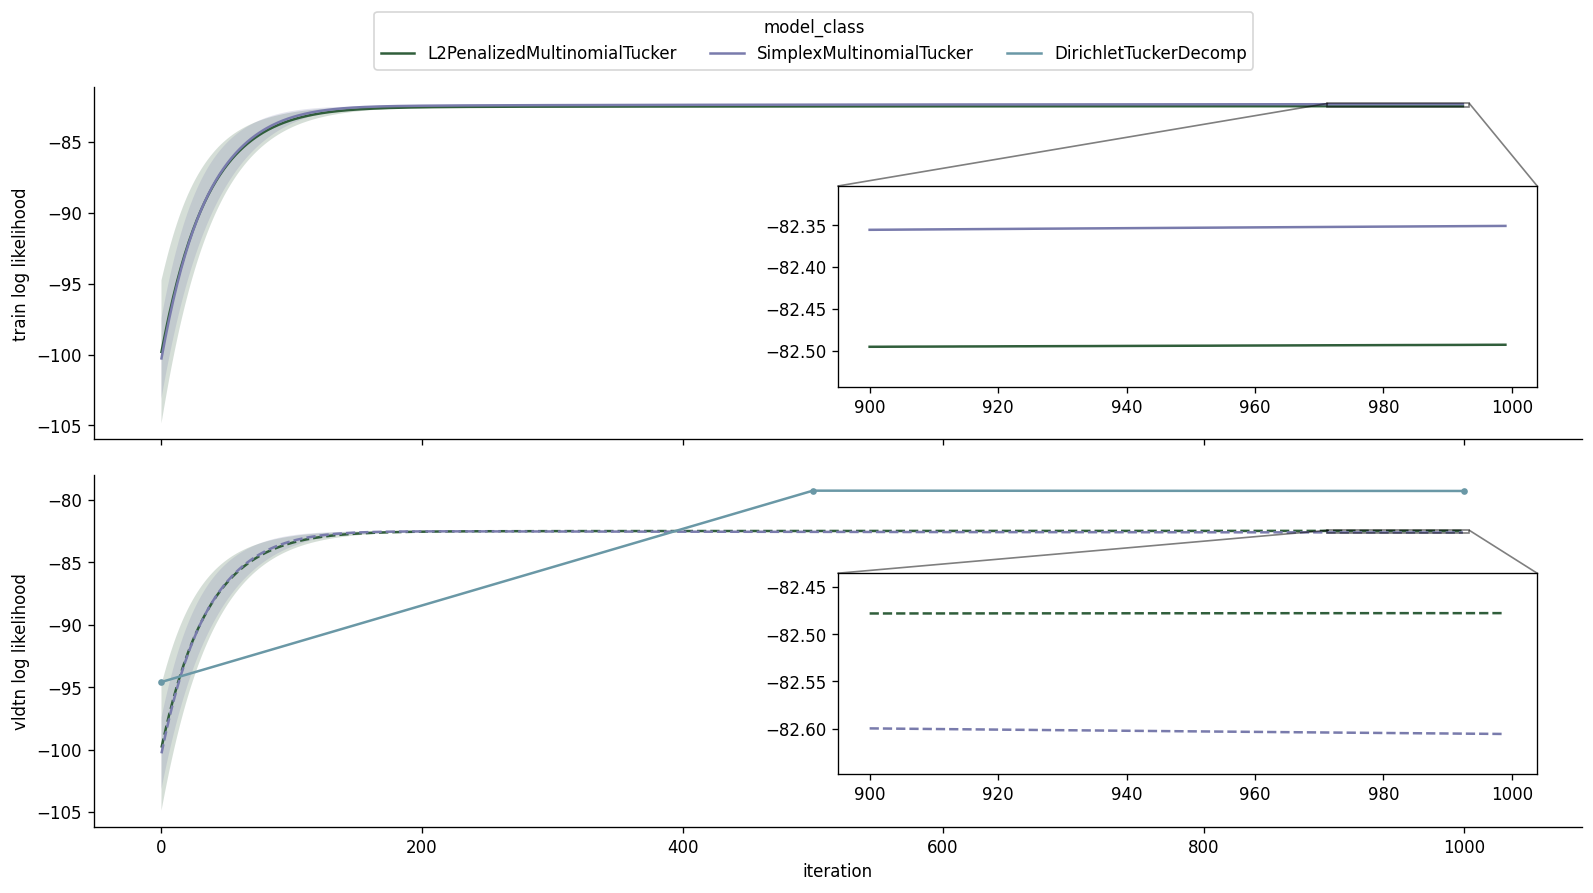

In [232]:
fig, axs = plt.subplots(nrows=2, sharex='col', gridspec_kw={'hspace':0.1},
                        figsize=(16,8), dpi=120)

inset_idxs = jnp.arange(n_iters-100, n_iters)

for i_row, (ll_type, ls) in enumerate([('train_ll', '-'), ('vldtn_ll', '--')]):
    ax_main = axs[i_row]
    ax_inset = ax_main.inset_axes([0.5, 0.15, 0.47, 0.57],)

    for i_model, (model_name, model_results) in enumerate(model_results_dict.items()):
        
        # ======================================================================
        # HACK
        # ----------------------------------------------------------------------
        if model_name == 'DirichletTuckerDecomp':
            continue
        # ======================================================================

        train_lls = model_results['train_ll']
        vldtn_lls = model_results['vldtn_ll']

        c_model = model_color_palette[i_model]

        ll = model_results[ll_type]
        ll_mean = jnp.mean(ll, axis=0)
        ll_std = jnp.std(ll, axis=0)
        
        ax_main.plot(jnp.arange(n_iters), ll_mean, c=c_model, ls=ls)
        ax_main.fill_between(jnp.arange(n_iters), ll_mean-ll_std, ll_mean+ll_std,
                            fc=c_model, alpha=0.2)
        
        ax_inset.plot(inset_idxs, ll_mean[inset_idxs], c=c_model, ls=ls)
        ax_main.fill_between(inset_idxs,
                            (ll_mean-ll_std)[inset_idxs],
                            (ll_mean+ll_std)[inset_idxs],
                            fc=c_model, alpha=0.1)
        
        sns.despine(ax=ax_main)

    # Increase inset margins
    ax_inset.margins(y=0.33)

    # Indicate inset
    ax_main.indicate_inset_zoom(ax_inset, edgecolor='black')

    ax_main.set_ylabel(f"{ll_type.split('_')[0]} log likelihood")
    sns.despine(ax=ax_main)

# =============================================================================
# HACK
# -----------------------------------------------------------------------------
dtd_vldtn_lls = onp.array([-94.57932, -79.257965, -79.28222])
dtd_vldtn_iters = onp.array([0, 500, 1000])

axs[-1].plot(dtd_vldtn_iters, dtd_vldtn_lls, marker='.', color=model_color_palette[-1])

# =============================================================================

axs[-1].set_xlabel('iteration')
# Add legend
handles = [
    mpl.lines.Line2D([0],[0], c=model_color_palette[i_weight], label=f'{weight}')
    for i_weight, weight in enumerate(model_results_dict.keys())
]

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=[0.5, 0.89],
           ncol=len(handles), title='model_class')


# fig.suptitle(f'{model_klass.__name__}', fontsize='x-large')

# Dirichlet Tucker

In [ ]:
dtd_vldtn_lls = onp.array([-94.57932, -79.257965, -79.28222])
dtd_vldtn_iters = onp.array([0, 500, 100])

In [225]:
model = DirichletTuckerDecomp(total_counts, *core_shape)
init_params = model.sample_params(key_dtd, *full_shape)

params, lps = model.fit(X, X_mask, init_params, 1000)

  0%|          | 0/500 [00:00<?, ?it/s]